In [1]:
import emat
emat.versions()

emat 0.5.1, plotly 4.14.3


# Feature Scoring

Feature scoring is a methodology for identifying what model inputs (in machine 
learning terminology, “features”) have the greatest relationship to the outputs.  
The relationship is not necessarily linear, but rather can be any arbitrary 
linear or non-linear relationship.  For example, consider the function:

In [2]:
import numpy

def demo(A=0,B=0,C=0,**unused):
    """
    Y = A/2 + sin(6πB) + ε
    """
    return {'Y':A/2 + numpy.sin(6 * numpy.pi * B) + 0.1 * numpy.random.random()}

We can readily tell from the functional form that the *B* term is the
most significant when all parameter vary in the unit interval, as the 
amplitude of the sine wave attached to *B* is 1 (although the relationship 
is clearly non-linear) while the maximum change
in the linear component attached to *A* is only one half, and the output
is totally unresponsive to *C*.

To demonstrate the feature scoring, we can define a scope to explore this 
demo model:

In [3]:
demo_scope = emat.Scope(scope_file='', scope_def="""---
scope:
    name: demo
inputs:
    A:
        ptype: exogenous uncertainty
        dtype: float
        min: 0
        max: 1
    B:
        ptype: exogenous uncertainty
        dtype: float
        min: 0
        max: 1
    C:
        ptype: exogenous uncertainty
        dtype: float
        min: 0
        max: 1
outputs:
    Y:  
        kind: info
""")

And then we will design and run some experiments to generate data used for
feature scoring.

In [4]:
from emat import PythonCoreModel
demo_model = PythonCoreModel(demo, scope=demo_scope)
experiments = demo_model.design_experiments(n_samples=5000)
experiment_results = demo_model.run_experiments(experiments)

In [5]:
from emat.analysis import feature_scores
fs = feature_scores(demo_scope, experiment_results)
fs

,A,B,C
Y,0.136464,0.784930,0.078605


<xmle.Elem 'img' with 0 children>
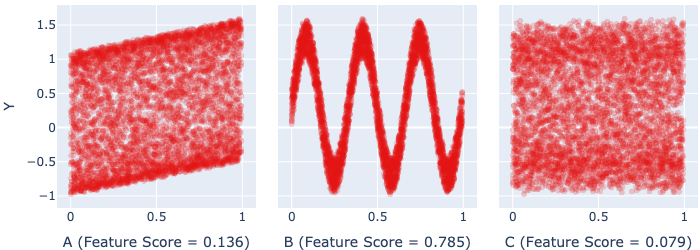

In [6]:
from emat.analysis import display_experiments
fig = display_experiments(demo_scope, experiment_results, render=False, return_figures=True)['Y']
fig.update_layout(
    xaxis_title_text =f"A (Feature Score = {fs.data.loc['Y','A']:.3f})",
    xaxis2_title_text=f"B (Feature Score = {fs.data.loc['Y','B']:.3f})",
    xaxis3_title_text=f"C (Feature Score = {fs.data.loc['Y','C']:.3f})",
)
from emat.util.rendering import render_plotly
render_plotly(fig, '.png')

One important thing to consider is that changing the range of the input parameters 
in the scope can significantly impact the feature scores, even if the underlying 
model itself is not changed.  For example, consider what happens to the features
scores when we expand the range of the uncertainties:

In [7]:
demo_model.scope = emat.Scope(scope_file='', scope_def="""---
scope:
    name: demo
inputs:
    A:
        ptype: exogenous uncertainty
        dtype: float
        min: 0
        max: 5
    B:
        ptype: exogenous uncertainty
        dtype: float
        min: 0
        max: 5
    C:
        ptype: exogenous uncertainty
        dtype: float
        min: 0
        max: 5
outputs:
    Y:  
        kind: info
""")

In [8]:
wider_experiments = demo_model.design_experiments(n_samples=5000)
wider_results = demo_model.run_experiments(wider_experiments)

In [9]:
from emat.analysis import feature_scores
wider_fs = feature_scores(demo_model.scope, wider_results)
wider_fs

,A,B,C
Y,0.772328,0.158978,0.068695


<xmle.Elem 'img' with 0 children>
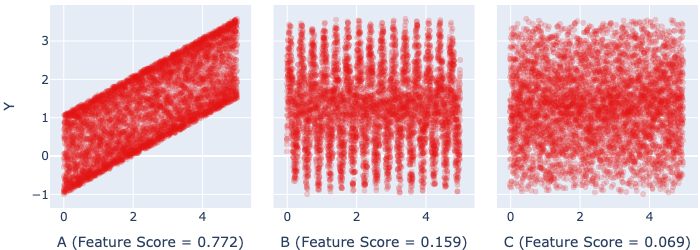

In [10]:
fig = display_experiments(demo_model.scope, wider_results, render=False, return_figures=True)['Y']
fig.update_layout(
    xaxis_title_text =f"A (Feature Score = {wider_fs.data.loc['Y','A']:.3f})",
    xaxis2_title_text=f"B (Feature Score = {wider_fs.data.loc['Y','B']:.3f})",
    xaxis3_title_text=f"C (Feature Score = {wider_fs.data.loc['Y','C']:.3f})",
)
render_plotly(fig, '.png')

The pattern has shifted, with the sine wave in *B* looking much more like the random noise,
while the linear trend in *A* is now much more important in predicting the output, and
the feature scores also shift to reflect this change.

## Road Test Feature Scores

We can apply the feature scoring methodology to the Road Test example 
in a similar fashion.  To demonstrate scoring, we'll first load and run
a sample set of experients.

In [11]:
from emat.model.core_python import Road_Capacity_Investment
road_scope = emat.Scope(emat.package_file('model','tests','road_test.yaml'))
road_test = PythonCoreModel(Road_Capacity_Investment, scope=road_scope)
road_test_design = road_test.design_experiments(sampler='lhs')
road_test_results = road_test.run_experiments(design=road_test_design)

In [12]:
feature_scores(road_scope, road_test_results)

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
no_build_travel_time,0.075293,0.068182,0.538393,0.046090,0.043536,0.045446,0.042912,0.041798,0.039350,0.030986,0.028014
build_travel_time,0.046962,0.047576,0.294707,0.048980,0.051786,0.061001,0.053346,0.274514,0.047741,0.038547,0.034840
time_savings,0.082390,0.089531,0.437443,0.046821,0.051698,0.050382,0.046855,0.086983,0.048425,0.030447,0.029026
value_of_time_savings,0.080125,0.064977,0.296455,0.196913,0.043270,0.051546,0.051619,0.086728,0.045814,0.043878,0.038676
net_benefits,0.073350,0.048033,0.274585,0.116004,0.048006,0.043684,0.058289,0.189976,0.065641,0.044471,0.037961
cost_of_capacity_expansion,0.037718,0.034734,0.048601,0.042841,0.084262,0.039434,0.044483,0.494295,0.103566,0.040153,0.029912
present_cost_expansion,0.038055,0.025013,0.029004,0.029836,0.086967,0.039247,0.035163,0.649856,0.025137,0.021536,0.020184


In [13]:
feature_scores(road_scope, road_test_results, return_type='dataframe')

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
no_build_travel_time,0.076455,0.067577,0.547147,0.038260,0.048396,0.042603,0.043010,0.038458,0.041105,0.032364,0.024624
build_travel_time,0.047886,0.051504,0.279975,0.060721,0.055445,0.053489,0.044081,0.300634,0.049298,0.027803,0.029163
time_savings,0.108482,0.069877,0.446738,0.040805,0.052594,0.046389,0.044383,0.085607,0.039477,0.036638,0.029010
value_of_time_savings,0.080945,0.070036,0.318382,0.156613,0.043204,0.047959,0.067452,0.089235,0.059085,0.037841,0.029249
net_benefits,0.066060,0.056216,0.271768,0.121979,0.054652,0.048983,0.047650,0.177654,0.077722,0.046306,0.031012
cost_of_capacity_expansion,0.034423,0.038636,0.043843,0.040750,0.080650,0.047269,0.045473,0.492494,0.106107,0.045416,0.024940
present_cost_expansion,0.031402,0.029665,0.026294,0.030246,0.081330,0.036982,0.024279,0.664286,0.029862,0.025960,0.019693


In [14]:
feature_scores(road_scope, road_test_results, return_type='figure')

<xmle.Elem 'div' with 1 children>

The colors on the returned DataFrame highlight the most important input features
for each performance measure (i.e., in each row).  The yellow highlighted cell 
indicates the most important input feature for each output feature, and the 
other cells are colored from yellow through green to blue, showing high-to-low
importance.  These colors are from matplotlib's default "viridis" colormap. 
A different colormap can be used by giving a named colormap in the `cmap`
argument.

In [15]:
feature_scores(road_scope, road_test_results, cmap='copper')

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
no_build_travel_time,0.067907,0.068892,0.545381,0.039791,0.048858,0.044914,0.038852,0.043290,0.039698,0.032160,0.030257
build_travel_time,0.040019,0.047880,0.286568,0.039084,0.048906,0.049377,0.055488,0.316152,0.042957,0.044400,0.029169
time_savings,0.083301,0.079282,0.433071,0.047197,0.049545,0.049384,0.053214,0.093971,0.043185,0.033031,0.034819
value_of_time_savings,0.084197,0.066246,0.315413,0.189313,0.051799,0.043885,0.054402,0.067124,0.054650,0.036482,0.036488
net_benefits,0.065213,0.062103,0.251974,0.117954,0.054434,0.045045,0.067021,0.191905,0.075528,0.040360,0.028463
cost_of_capacity_expansion,0.040910,0.037305,0.049215,0.040266,0.081726,0.046242,0.045754,0.489732,0.095459,0.044652,0.028739
present_cost_expansion,0.027351,0.017587,0.025910,0.028115,0.085811,0.032409,0.026658,0.674268,0.032287,0.027821,0.021783


You may also notice small changes in the numbers given in the two tables above. This
occurs because the underlying algorithm for scoring uses a random trees algorithm. If
you need to have stable (replicable) results, you can provide an integer in the 
`random_state` argument.

In [16]:
feature_scores(road_scope, road_test_results, random_state=1, cmap='bone')

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
no_build_travel_time,0.069742,0.067682,0.557708,0.038260,0.037500,0.043854,0.039635,0.045330,0.046019,0.029962,0.024308
build_travel_time,0.038978,0.052516,0.294415,0.036316,0.042900,0.048776,0.049931,0.331223,0.040332,0.030027,0.034586
time_savings,0.084854,0.084775,0.427335,0.056313,0.045476,0.050672,0.041260,0.090572,0.047126,0.040557,0.031062
value_of_time_savings,0.076504,0.055238,0.334227,0.177406,0.045623,0.038967,0.071869,0.075423,0.046744,0.043492,0.034506
net_benefits,0.068594,0.050820,0.270457,0.113781,0.049488,0.051259,0.069530,0.181702,0.077212,0.036118,0.031038
cost_of_capacity_expansion,0.038307,0.036459,0.044803,0.049044,0.076379,0.039507,0.043260,0.489785,0.119787,0.038756,0.023914
present_cost_expansion,0.032561,0.032959,0.038989,0.040957,0.107123,0.041828,0.040684,0.588281,0.025878,0.030009,0.020731


Then if we call the function again with the same `random_state`, we get the same numerical result.

In [17]:
feature_scores(road_scope, road_test_results, random_state=1, cmap='YlOrRd')

,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
no_build_travel_time,0.069742,0.067682,0.557708,0.038260,0.037500,0.043854,0.039635,0.045330,0.046019,0.029962,0.024308
build_travel_time,0.038978,0.052516,0.294415,0.036316,0.042900,0.048776,0.049931,0.331223,0.040332,0.030027,0.034586
time_savings,0.084854,0.084775,0.427335,0.056313,0.045476,0.050672,0.041260,0.090572,0.047126,0.040557,0.031062
value_of_time_savings,0.076504,0.055238,0.334227,0.177406,0.045623,0.038967,0.071869,0.075423,0.046744,0.043492,0.034506
net_benefits,0.068594,0.050820,0.270457,0.113781,0.049488,0.051259,0.069530,0.181702,0.077212,0.036118,0.031038
cost_of_capacity_expansion,0.038307,0.036459,0.044803,0.049044,0.076379,0.039507,0.043260,0.489785,0.119787,0.038756,0.023914
present_cost_expansion,0.032561,0.032959,0.038989,0.040957,0.107123,0.041828,0.040684,0.588281,0.025878,0.030009,0.020731


## Interpreting Feature Scores

The correct interpretation of feature scores is obviously important.  As noted above,
the feature scores can reveal both linear and non-linear relationships. But the scores
themselves give no information about which is which. 

In addition, while the default feature scoring algorithm generates scores that total 
to 1.0, it does not necessarily map to dividing up the explained variance. Factors that
have little to no effect on the output still are given non-zero feature score values.
You can see an example of this in the "demo" function above; that simple example 
literally ignores the "C" input, but it has a non-zero score assigned.  If there are
a large number of superfluous inputs, they will appear to reduce the scores attached
to the meaningful inputs.

It is also important to remember that these scores do not fully reflect 
any asymmetric relationships in the data. A feature may be very important for some portion
of the range of a performance measure, and less important in other parts of the range.
For example, in the Road Test model, the "expand_capacity" lever has a highly asymmetric
impact on the "net_benefits" measure: it is very important in
determining negative values (when congestion isn't going to be bad due to low "input_flow" volumes, 
the net loss is limited by how much we spend), but not so important for positive values 
(nearly any amount of expansion has a big payoff if congestion is going to be bad due 
to high "input_flow" volume).  If we plot this three-way relationship specifically, we can 
observe it on one figure:

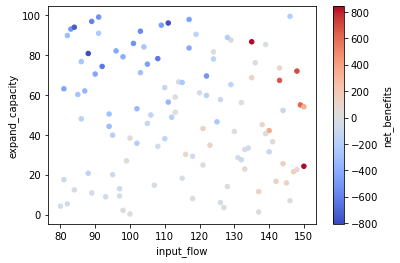

In [18]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax = road_test_results.plot.scatter(
    c='net_benefits', 
    y='expand_capacity', 
    x='input_flow', 
    cmap='coolwarm',
    ax=ax,
)

Looking at the figure above, we can see the darker red clustered to the right,
and the darker blue clustered in the top left.
However, if we are not aware of this particular three-way relationship
*a priori*, it may be difficult to discover it by looking through various
combinations of three-way relationships.  To uncover this kind of relationship,
threshold scoring may be useful.

## Threshold Scoring

In [19]:
from emat.analysis.feature_scoring import threshold_feature_scores

threshold_feature_scores(road_scope, 'net_benefits', road_test_results)

,-596.2998419053935,-532.2177460113968,-468.1356501174002,-404.0535542234036,-339.9714583294069,-275.88936243541025,-211.80726654141364,-147.72517064741703,-83.64307475342036,-19.5609788594237,44.52111703457297,108.60321292856952,172.68530882256618,236.76740471656285,300.8495006105594,364.93159650455607,429.01369239855273,493.0957882925494,557.1778841865461,621.2599800805428
alpha,0.075148,0.050279,0.059898,0.103448,0.117437,0.077087,0.059059,0.065693,0.045667,0.072984,0.079683,0.078461,0.063940,0.071503,0.067585,0.101356,0.084803,0.076406,0.091555,0.075858
beta,0.062863,0.065949,0.071284,0.070418,0.041685,0.053184,0.055833,0.057309,0.060744,0.055626,0.061131,0.069423,0.087561,0.087615,0.093054,0.061921,0.076819,0.111758,0.075494,0.077963
input_flow,0.099042,0.117610,0.121540,0.133525,0.157956,0.202672,0.194030,0.178355,0.203482,0.291356,0.328865,0.281785,0.262936,0.256167,0.221948,0.221820,0.186323,0.224079,0.236539,0.202316
value_of_time,0.092756,0.090173,0.070189,0.052254,0.061863,0.079276,0.053757,0.073133,0.104445,0.137612,0.088578,0.097355,0.138259,0.137003,0.136594,0.152264,0.184779,0.188427,0.180954,0.166136
unit_cost_expansion,0.101838,0.079997,0.072786,0.052329,0.058754,0.076293,0.068773,0.052392,0.055921,0.064583,0.068868,0.070714,0.067171,0.050264,0.047013,0.045760,0.062143,0.058584,0.053345,0.080208
interest_rate,0.060629,0.055555,0.064587,0.057517,0.058705,0.055403,0.060793,0.053051,0.072146,0.063817,0.075683,0.079550,0.073380,0.059745,0.071573,0.058264,0.047997,0.070229,0.071760,0.061203
yield_curve,0.056337,0.085194,0.083580,0.061164,0.054890,0.046631,0.060609,0.054925,0.063682,0.062777,0.074276,0.076540,0.104534,0.100175,0.105485,0.131876,0.132665,0.071773,0.091659,0.099439
expand_capacity,0.125463,0.210470,0.260424,0.307043,0.240281,0.248223,0.294557,0.318593,0.237247,0.105743,0.064666,0.068426,0.045452,0.052989,0.052125,0.046287,0.084356,0.057788,0.057288,0.094136
amortization_period,0.209180,0.172479,0.103268,0.073847,0.103093,0.083261,0.070993,0.071950,0.060059,0.063213,0.056224,0.080024,0.060268,0.088706,0.090940,0.104742,0.059355,0.068531,0.058589,0.071917
debt_type,0.076596,0.039295,0.063979,0.061042,0.072186,0.049546,0.046141,0.046417,0.059387,0.047572,0.055698,0.055564,0.049843,0.047698,0.065033,0.034613,0.039652,0.035859,0.042966,0.041564


<xmle.Elem 'img' with 0 children>
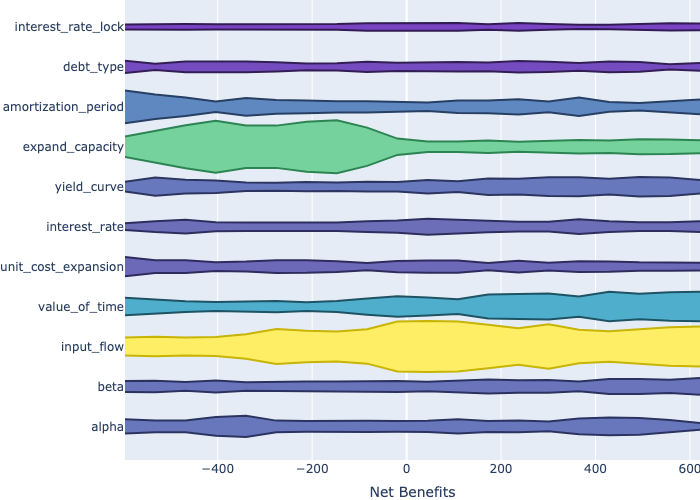

In [20]:
threshold_feature_scores(road_scope, 'net_benefits', road_test_results, return_type='figure.png')

In [21]:
threshold_feature_scores(road_scope, 'net_benefits', road_test_results, return_type='ridge figure.svg')

<xmle.Elem '{http://www.w3.org/2000/svg}svg' with 16 children>

In these figures, we can see that "expand_capacity" is important for negative outcomes,
but for positive outcomes we should focus more on "input_flow", and to a lesser but
still meaningful extent also "value_of_time".

## Feature Scoring API 